In [8]:
import os
from dotenv import load_dotenv
# If your .env is not in the CWD, point to it explicitly:
# load_dotenv(dotenv_path=r"C:\path\to\.env")
load_dotenv()

for k in ("MYSQL_USER","MYSQL_PWD","MYSQL_HOST","MYSQL_PORT","MYSQL_DB"):
    print(k, "=", os.getenv(k))


MYSQL_USER = root
MYSQL_PWD = your_password
MYSQL_HOST = 127.0.0.1
MYSQL_PORT = 3306
MYSQL_DB = FoodExpressDB


In [9]:
import os
from dotenv import load_dotenv
from pathlib import Path

env_path = Path.cwd() / ".env"  # change if your .env lives elsewhere
load_dotenv(dotenv_path=env_path, override=True)

def mask(v): 
    return None if v is None else (v[:2] + "*****" if len(v) > 2 else "***")

print("USER:", os.getenv("MYSQL_USER"))
print("PWD :", mask(os.getenv("MYSQL_PWD")))
print("HOST:", os.getenv("MYSQL_HOST"))
print("PORT:", os.getenv("MYSQL_PORT"))
print("DB  :", os.getenv("MYSQL_DB"))


USER: root
PWD : Sa*****
HOST: 127.0.0.1
PORT: 3306
DB  : FoodExpressDB


In [13]:
import os
from urllib.parse import quote_plus
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

load_dotenv()

USER = os.getenv("MYSQL_USER")
PWD  = os.getenv("MYSQL_PWD")            # raw: Sathiya@123
HOST = os.getenv("MYSQL_HOST", "127.0.0.1")
PORT = os.getenv("MYSQL_PORT", "3306")
DB   = os.getenv("MYSQL_DB", "FoodExpressDB")

# URL-encode the password so '@' becomes '%40'
PWDQ = quote_plus(PWD)                   # -> 'Sathiya%40123'

URL = f"mysql+mysqlconnector://{USER}:{PWDQ}@{HOST}:{PORT}/{DB}"
engine = create_engine(URL, pool_pre_ping=True)

with engine.connect() as conn:
    print("Ping:", conn.execute(text("SELECT 1")).scalar())
    print("DB  :", conn.execute(text("SELECT DATABASE()")).scalar())


Ping: 1
DB  : foodexpressdb


In [14]:
import pandas as pd
from sqlalchemy import text

tables = [
    "users","customers","addresses","restaurants","menus","menu_items",
    "couriers","orders","order_items","payments","deliveries","reviews"
]
q = " UNION ALL ".join([f"SELECT '{t}' AS table_name, COUNT(*) AS row_count FROM {t}" for t in tables])
pd.read_sql(text(q), engine)


,table_name,row_count
0,users,104
1,customers,60
2,addresses,76
3,restaurants,18
4,menus,18
5,menu_items,180
6,couriers,25
7,orders,220
8,order_items,669
9,payments,220


In [15]:
top_customers = pd.read_sql(text("""
    SELECT customer_id, full_name, total_orders, total_spent, avg_order_value, delivered_orders
    FROM v_customer_order_summary
    ORDER BY total_spent DESC
    LIMIT 10;
"""), engine)
top_customers


,customer_id,full_name,total_orders,total_spent,avg_order_value,delivered_orders
0,1080,James Clark,9,930.38,103.375556,1.0
1,1089,Olivia Lewis,7,848.98,121.282857,0.0
2,1052,Ethan Baker,6,843.95,140.658333,2.0
3,1061,Harper Chen,6,712.88,118.813333,1.0
4,1060,Jack Martin,7,695.19,99.312857,1.0
5,1104,Elijah Martin,5,690.48,138.096000,3.0
6,1102,Charlotte Walker,6,680.97,113.495000,3.0
7,1054,Olivia Brown,6,677.58,112.930000,2.0
8,1083,Evelyn Hill,6,609.39,101.565000,1.0
9,1077,Ethan Moore,4,605.91,151.477500,1.0


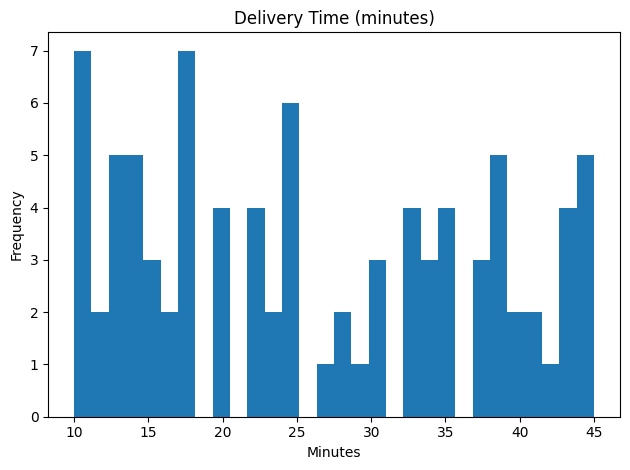

In [16]:
delivery_times = pd.read_sql(text("""
    SELECT TIMESTAMPDIFF(MINUTE, d.pickup_time, d.dropoff_time) AS minutes_to_deliver
    FROM deliveries d
    WHERE d.status='delivered' AND d.dropoff_time IS NOT NULL;
"""), engine)

import matplotlib.pyplot as plt
plt.figure()
delivery_times['minutes_to_deliver'].plot(kind='hist', bins=30, title='Delivery Time (minutes)')
plt.xlabel('Minutes')
plt.tight_layout()
plt.show()


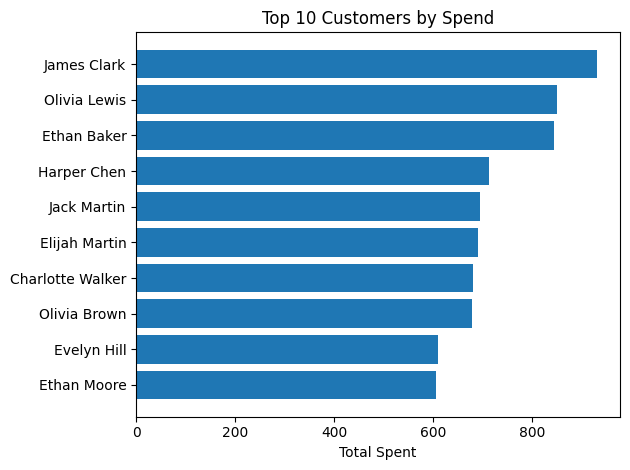

In [19]:
# top 10 customers by spend
tc10 = top_customers.nlargest(10, 'total_spent').sort_values('total_spent')
plt.figure(); plt.barh(tc10['full_name'], tc10['total_spent'])
plt.title('Top 10 Customers by Spend'); plt.xlabel('Total Spent'); plt.tight_layout(); plt.show()

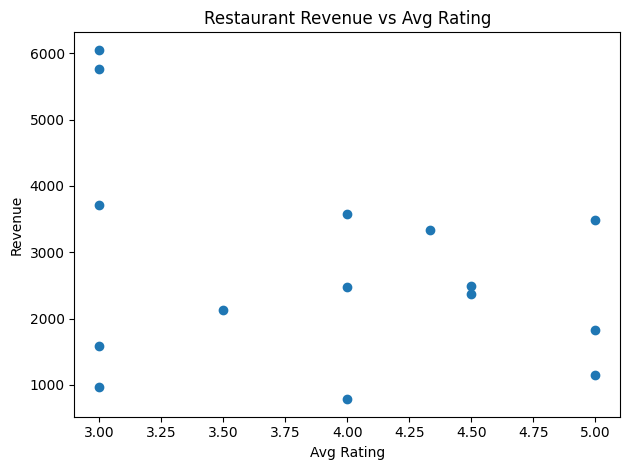

In [20]:
rest_perf = pd.read_sql(text("""
    SELECT restaurant_id, restaurant_name, orders_count, revenue, avg_rating
    FROM v_restaurant_performance
    ORDER BY revenue DESC
    LIMIT 20;
"""), engine)

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(pd.to_numeric(rest_perf['avg_rating'], errors='coerce'),
            pd.to_numeric(rest_perf['revenue'], errors='coerce'))
plt.title('Restaurant Revenue vs Avg Rating')
plt.xlabel('Avg Rating'); plt.ylabel('Revenue')
plt.tight_layout(); plt.show()


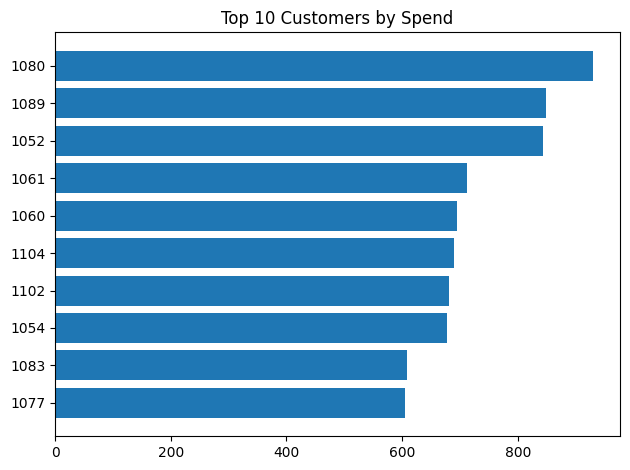

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       0.00      0.00      0.00         2

    accuracy                           0.87        15
   macro avg       0.43      0.50      0.46        15
weighted avg       0.75      0.87      0.80        15



c:\Users\sathiyabama\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sathiyabama\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sathiyabama\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

In [21]:
# 1) Pull from SQL
df = pd.read_sql(text("""
  SELECT customer_id, total_orders, total_spent, avg_order_value
  FROM v_customer_order_summary
"""), engine)

# 2) Quick viz
import matplotlib.pyplot as plt
tc10 = df.nlargest(10, 'total_spent').sort_values('total_spent')
plt.figure(); plt.barh(tc10['customer_id'].astype(str), tc10['total_spent'])
plt.title('Top 10 Customers by Spend'); plt.tight_layout(); plt.show()

# 3) Simple ML (churn proxy: inactive if total_orders <= 1)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

df_ml = df.fillna(0).copy()
df_ml['inactive'] = (df_ml['total_orders'] <= 1).astype(int)
X = df_ml[['total_orders','avg_order_value']]
y = df_ml['inactive']
Xtr, Xte, ytr, yte = train_test_split(X, y, stratify=y, random_state=42)
clf = LogisticRegression(max_iter=1000).fit(Xtr, ytr)
print(classification_report(yte, clf.predict(Xte)))


In [22]:
import pandas as pd
from sqlalchemy import text

df = pd.read_sql(text("SELECT * FROM ML_Customer_Retention_Dataset"), engine)
display(df.head())
df.to_csv("customer_retention_dataset.csv", index=False)


,customer_id,days_as_customer,likes_spicy,favorite_cuisines_count,total_orders,delivered_orders,cancelled_orders,avg_feedback_rating,total_spent,pm_card_share,pm_wallet_share,pm_cash_share,tracking_share,retention_category,is_active_recent_60d
0,1045,46,0,None,4.0,1.0,0.0,2.0,456.25,0.0,0.0,0.0,1.0,Low_Activity,1
1,1046,30,0,None,3.0,1.0,0.0,5.0,239.55,0.0,0.0,0.0,1.0,Low_Activity,1
2,1047,14,0,None,4.0,2.0,2.0,3.0,401.52,0.0,0.0,0.0,1.0,Low_Activity,1
3,1048,134,0,None,4.0,1.0,0.0,5.0,369.29,0.0,0.0,0.0,1.0,Low_Activity,1
4,1049,11,1,None,2.0,0.0,0.0,NaN,236.80,0.0,0.0,0.0,1.0,Low_Activity,1


In [23]:
import pandas as pd
from sqlalchemy import text

df = pd.read_sql(text("SELECT * FROM ML_Customer_Retention_Dataset"), engine)

# Basic NA/typing safety (if needed)
num_cols = df.select_dtypes(include="number").columns
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

df.to_csv("customer_retention_dataset.csv", index=False)
display(df.head(10))
print("Rows:", len(df))


,customer_id,days_as_customer,likes_spicy,favorite_cuisines_count,total_orders,delivered_orders,cancelled_orders,avg_feedback_rating,total_spent,pm_card_share,pm_wallet_share,pm_cash_share,tracking_share,retention_category,is_active_recent_60d
0,1045,46,0,None,4.0,1.0,0.0,2.0,456.25,0.0,0.0,0.0,1.0,Low_Activity,1
1,1046,30,0,None,3.0,1.0,0.0,5.0,239.55,0.0,0.0,0.0,1.0,Low_Activity,1
2,1047,14,0,None,4.0,2.0,2.0,3.0,401.52,0.0,0.0,0.0,1.0,Low_Activity,1
3,1048,134,0,None,4.0,1.0,0.0,5.0,369.29,0.0,0.0,0.0,1.0,Low_Activity,1
4,1049,11,1,None,2.0,0.0,0.0,0.0,236.80,0.0,0.0,0.0,1.0,Low_Activity,1
5,1050,189,1,None,5.0,2.0,1.0,5.0,524.51,0.0,0.0,0.0,1.0,Medium_Activity,1
6,1051,66,0,None,4.0,1.0,0.0,0.0,256.14,0.0,0.0,0.0,1.0,Low_Activity,1
7,1052,91,0,None,6.0,2.0,1.0,0.0,843.95,0.0,0.0,0.0,1.0,Medium_Activity,1
8,1053,146,1,None,5.0,1.0,2.0,0.0,362.87,0.0,0.0,0.0,1.0,Medium_Activity,1
9,1054,28,0,None,6.0,2.0,1.0,5.0,677.58,0.0,0.0,0.0,1.0,Medium_Activity,1


Rows: 60


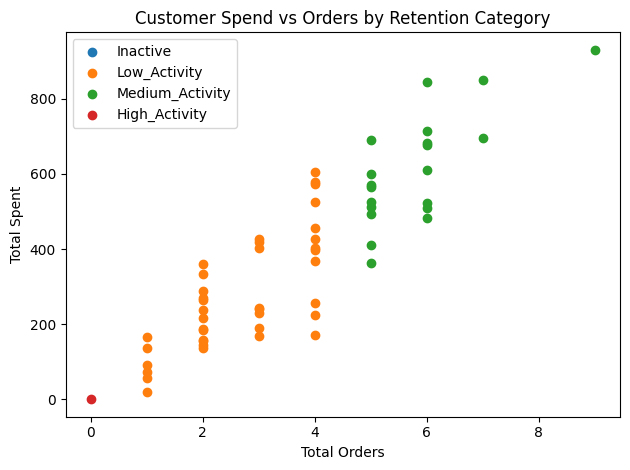

In [24]:
import matplotlib.pyplot as plt
df["total_orders"] = pd.to_numeric(df["total_orders"], errors="coerce").fillna(0)
plt.figure()
for cat in ["Inactive","Low_Activity","Medium_Activity","High_Activity"]:
    sub = df[df["retention_category"]==cat]
    plt.scatter(sub["total_orders"], sub["total_spent"], label=cat)
plt.title("Customer Spend vs Orders by Retention Category")
plt.xlabel("Total Orders"); plt.ylabel("Total Spent")
plt.legend(); plt.tight_layout(); plt.show()


Loaded rows: 173
Columns: ['delivery_id', 'order_id', 'restaurant_id', 'courier_id', 'minutes_to_deliver', 'failed_flag', 'order_hour', 'order_dow', 'is_weekend', 'is_peak', 'prep_minutes', 'vehicle_type', 'has_tracking', 'rest_avg_minutes_30d', 'rest_fail_rate_30d', 'courier_avg_minutes_30d', 'courier_fail_rate_30d']


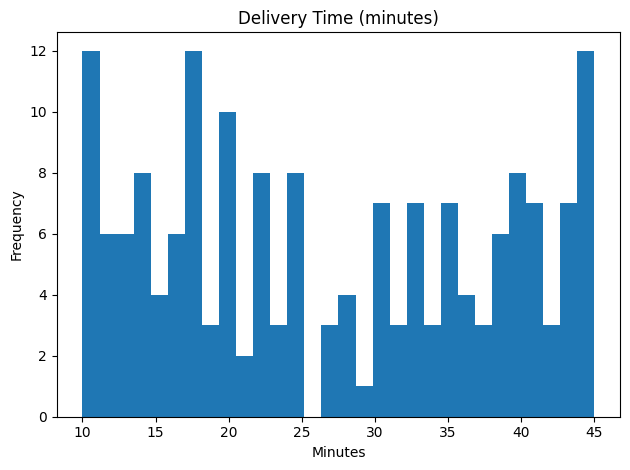

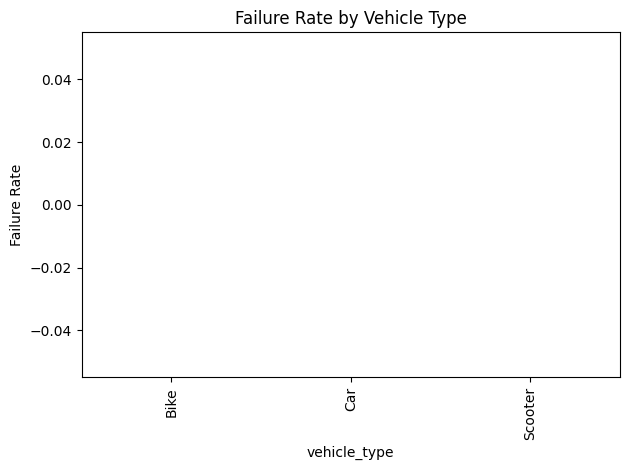

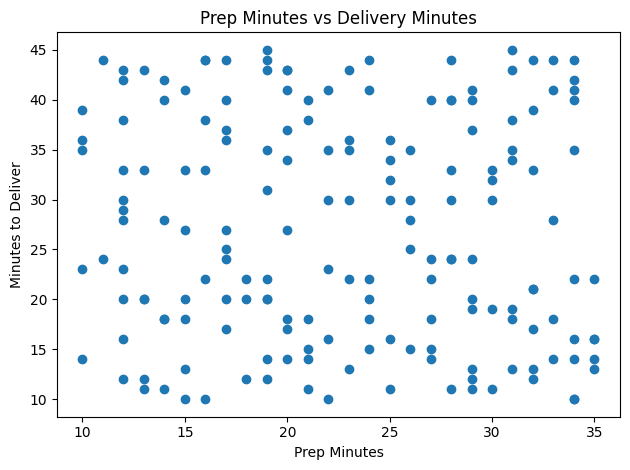

X_reg shape: (173, 15) | y_reg: (173,)
X_clf shape: (173, 15) | y_clf: (173,)

[Regression] RandomForestRegressor
MAE: 9.08152380952381
R^2: 0.040608829226879695

[Classification] RandomForestClassifier
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        35

    accuracy                          1.000        35
   macro avg      1.000     1.000     1.000        35
weighted avg      1.000     1.000     1.000        35



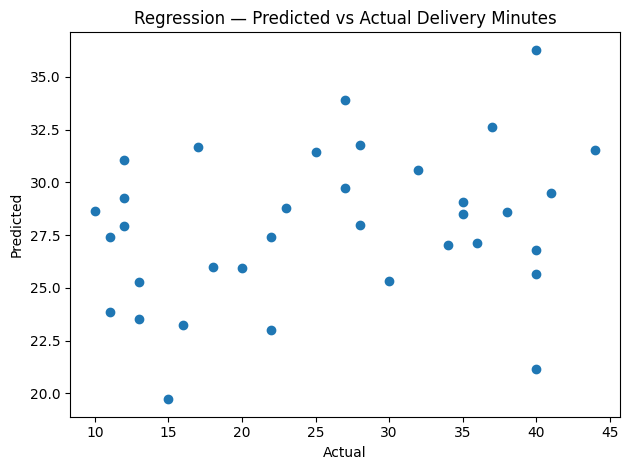

In [27]:
# === 0) Imports ===
import pandas as pd
import numpy as np
from sqlalchemy import text
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, classification_report
import matplotlib.pyplot as plt

# === 1) Load the view from MySQL ===
df_deliv = pd.read_sql(text("SELECT * FROM ML_Delivery_Performance_Dataset"), engine)
print("Loaded rows:", len(df_deliv))
print("Columns:", list(df_deliv.columns))

# Basic numeric coercion and NA fill (safe default)
num_cols_all = df_deliv.select_dtypes(include="number").columns
df_deliv[num_cols_all] = df_deliv[num_cols_all].apply(pd.to_numeric, errors="coerce")
df_deliv[num_cols_all] = df_deliv[num_cols_all].fillna(0)

# Make sure classification target is int/binary
if "failed_flag" in df_deliv.columns:
    df_deliv["failed_flag"] = df_deliv["failed_flag"].astype(int)

# === 2) Quick sanity plots on the raw view ===
# 2a) Histogram of delivery minutes (regression target)
if "minutes_to_deliver" in df_deliv.columns:
    plt.figure()
    df_deliv["minutes_to_deliver"].plot(kind="hist", bins=30, title="Delivery Time (minutes)")
    plt.xlabel("Minutes")
    plt.tight_layout()
    plt.show()

# 2b) Failed rate by vehicle_type
if "vehicle_type" in df_deliv.columns and "failed_flag" in df_deliv.columns:
    rate_by_vehicle = df_deliv.groupby("vehicle_type")["failed_flag"].mean().sort_values()
    plt.figure()
    rate_by_vehicle.plot(kind="bar", title="Failure Rate by Vehicle Type")
    plt.ylabel("Failure Rate")
    plt.tight_layout()
    plt.show()

# 2c) Scatter: prep time vs minutes_to_deliver (if both exist)
if {"prep_minutes", "minutes_to_deliver"}.issubset(df_deliv.columns):
    plt.figure()
    plt.scatter(df_deliv["prep_minutes"], df_deliv["minutes_to_deliver"])
    plt.title("Prep Minutes vs Delivery Minutes")
    plt.xlabel("Prep Minutes")
    plt.ylabel("Minutes to Deliver")
    plt.tight_layout()
    plt.show()

# === 3) Feature/target splits (safe drop for columns that may not exist) ===
cols_to_drop = ["minutes_to_deliver", "failed_flag", "order_time", "restaurant_name"]
drop_existing = [c for c in cols_to_drop if c in df_deliv.columns]

# Regression dataset (predict minutes_to_deliver)
reg_df = df_deliv.copy()
reg_df = reg_df.dropna(subset=["minutes_to_deliver"])
y_reg = reg_df["minutes_to_deliver"]
X_reg = reg_df.drop(columns=drop_existing, errors="ignore")

# Classification dataset (predict failed_flag)
clf_df = df_deliv.copy()
clf_df = clf_df.dropna(subset=["failed_flag"])
y_clf = clf_df["failed_flag"].astype(int)
X_clf = clf_df.drop(columns=drop_existing, errors="ignore")

print("X_reg shape:", X_reg.shape, "| y_reg:", y_reg.shape)
print("X_clf shape:", X_clf.shape, "| y_clf:", y_clf.shape)

# Identify numeric vs categorical features for preprocessing
def split_feature_types(df):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=["object","category","bool","string"]).columns.tolist()
    return num_cols, cat_cols

num_reg, cat_reg = split_feature_types(X_reg)
num_clf, cat_clf = split_feature_types(X_clf)

# === 4) Preprocessors ===
numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

# OneHotEncoder API changes slightly across versions; use sparse_output if available
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preproc_reg = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_reg),
        ("cat", categorical_tf, cat_reg),
    ],
    remainder="drop"
)

preproc_clf = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_clf),
        ("cat", categorical_tf, cat_clf),
    ],
    remainder="drop"
)

# === 5) Train/test splits ===
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

# === 6) Pipelines + models ===
reg_pipe = Pipeline(steps=[
    ("prep", preproc_reg),
    ("model", RandomForestRegressor(
        n_estimators=300, random_state=42, n_jobs=-1
    ))
])

clf_pipe = Pipeline(steps=[
    ("prep", preproc_clf),
    ("model", RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight="balanced", n_jobs=-1
    ))
])

# === 7) Fit & evaluate ===
# Regression
reg_pipe.fit(Xr_train, yr_train)
yr_pred = reg_pipe.predict(Xr_test)
print("\n[Regression] RandomForestRegressor")
print("MAE:", mean_absolute_error(yr_test, yr_pred))
print("R^2:", r2_score(yr_test, yr_pred))

# Classification
clf_pipe.fit(Xc_train, yc_train)
yc_pred = clf_pipe.predict(Xc_test)
print("\n[Classification] RandomForestClassifier")
print(classification_report(yc_test, yc_pred, digits=3, zero_division=0))

# === 8) Simple model-result plots ===
# 8a) Regression: predicted vs actual scatter
plt.figure()
plt.scatter(yr_test, yr_pred)
plt.title("Regression — Predicted vs Actual Delivery Minutes")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()




Vehicle type counts:
 vehicle_type
Scooter    70
Car        52
Bike       51
Name: count, dtype: int64 

Failed flag distribution:
 failed_flag
0    173
Name: count, dtype: int64 


Failure summary by vehicle_type:
                n  failures  rate
vehicle_type                    
Bike          51         0   0.0
Car           52         0   0.0
Scooter       70         0   0.0 



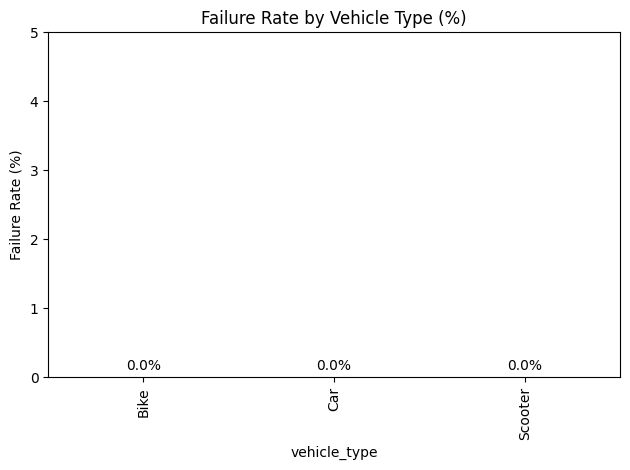

In [29]:
# ==== Failure rate by vehicle type (robust) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) Basic cleanup
if "failed_flag" not in df_deliv.columns:
    raise ValueError("Column 'failed_flag' not found in ML_Delivery_Performance_Dataset.")
df = df_deliv.copy()

# Ensure binary int and clean vehicle_type labels
df["failed_flag"] = pd.to_numeric(df["failed_flag"], errors="coerce").fillna(0).astype(int)
df["vehicle_type"] = (
    df.get("vehicle_type")
      .fillna("Unknown")
      .astype(str)
      .str.strip()
      .str.replace(r"\s+", " ", regex=True)
      .str.title()
)

# 1) Quick diagnostics
print("Vehicle type counts:\n", df["vehicle_type"].value_counts(dropna=False), "\n")
print("Failed flag distribution:\n", df["failed_flag"].value_counts(dropna=False), "\n")

# 2) Aggregate: count, failures, rate
vt = (
    df.groupby("vehicle_type", dropna=False)["failed_flag"]
      .agg(n="size", failures="sum", rate="mean")
      .sort_values("rate", ascending=False)
)

print("\nFailure summary by vehicle_type:\n", vt, "\n")

# Guard: nothing to plot?
if vt.empty:
    print("No rows to plot. Check that your view returns data and vehicle_type exists.")
else:
    # 3) Plot as percentages
    rates_pct = (vt["rate"] * 100).round(2)
    ax = rates_pct.plot(kind="bar", title="Failure Rate by Vehicle Type (%)")
    ax.set_ylabel("Failure Rate (%)")
    # Put value labels on bars
    for p, val in zip(ax.patches, rates_pct.values):
        ax.annotate(f"{val:.1f}%", (p.get_x() + p.get_width()/2, p.get_height()),
                    ha="center", va="bottom", xytext=(0, 3), textcoords="offset points")
    plt.ylim(0, max(5, rates_pct.max() * 1.15))  # add headroom; show small rates too
    plt.tight_layout()
    plt.show()


   restaurant_id restaurant_name  orders_count  revenue  avg_order_value  \
0           5001     Happy House            10  1184.37       118.437000   
1           5002     Royal Diner            15  1826.78       121.785333   
2           5003   Urban Kitchen            11   841.20        76.472727   
3           5004    Spice Lounge            18  1590.73        88.373889   
4           5005      Urban Fork            11  1249.25       113.568182   

   unique_customers  repeat_customers  reorder_rate  avg_rating  review_count  \
0                 8               1.0        0.1250         4.5             2   
1                14               1.0        0.0714         5.0             1   
2                11               0.0        0.0000         0.0             0   
3                17               1.0        0.0588         3.0             1   
4                10               1.0        0.1000         4.5             2   

   avg_delivery_minutes  fail_rate  menu_items_count  or

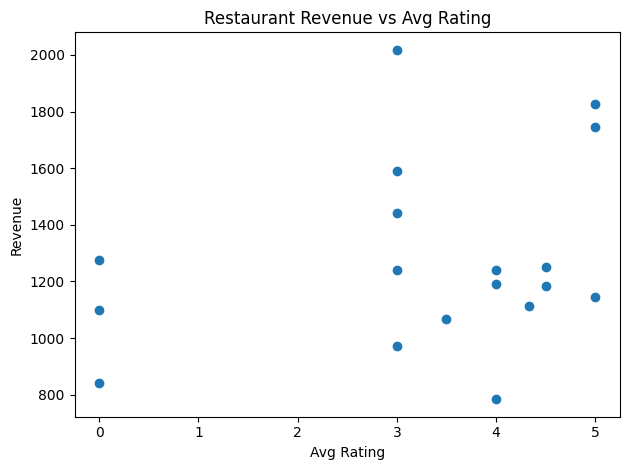

segment
0     3
1    11
2     4
Name: count, dtype: int64


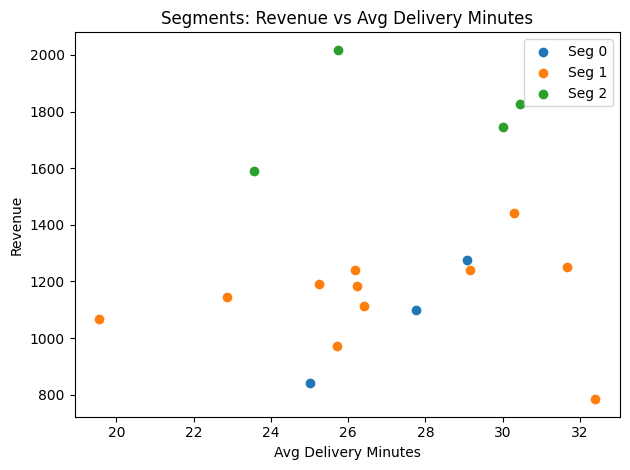

In [28]:
import pandas as pd
from sqlalchemy import text
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load
rest = pd.read_sql(text("SELECT * FROM ML_Restaurant_KPI_Dataset"), engine)

# Basic numeric cleanup
num_cols = rest.select_dtypes(include="number").columns
rest[num_cols] = rest[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

print(rest.head())
print("Rows:", len(rest))

# --- Example 1: quick scatter (Revenue vs Avg Rating)
plt.figure()
plt.scatter(rest["avg_rating"], rest["revenue"])
plt.title("Restaurant Revenue vs Avg Rating")
plt.xlabel("Avg Rating"); plt.ylabel("Revenue")
plt.tight_layout(); plt.show()

# --- Example 2: simple clustering on KPIs
kpi_cols = ["revenue","orders_count","avg_rating","avg_delivery_minutes","fail_rate","reorder_rate","menu_items_count"]
X = rest[kpi_cols].copy()
X_scaled = StandardScaler(with_mean=False).fit_transform(X)  # sparse-safe

km = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels = km.fit_predict(X_scaled)
rest["segment"] = labels

# Segment sizes
print(rest["segment"].value_counts().sort_index())

# Visualize clusters in 2D proxy (revenue vs avg_delivery_minutes)
plt.figure()
for s in sorted(rest["segment"].unique()):
    sub = rest[rest["segment"]==s]
    plt.scatter(sub["avg_delivery_minutes"], sub["revenue"], label=f"Seg {s}")
plt.title("Segments: Revenue vs Avg Delivery Minutes")
plt.xlabel("Avg Delivery Minutes"); plt.ylabel("Revenue")
plt.legend(); plt.tight_layout(); plt.show()
